# AnnNet Showcase — edges, interop, SBML, and `.annnet` I/O

This notebook demonstrates:
- constructing a graph with **all edge types** supported (binary directed/undirected, self-loops, parallel edges, vertex–edge links, and k‑ary hyperedges),
- quick inspection & visualization,
- running algorithms in **NetworkX (NX)** via the lazy proxy,
- importing a repressilator (Elowitz) model from **SBML (Systems Biology Markup Language)**,
- and saving/loading the lossless **`.annnet`** format.

> Tip: the `G.nx.<algo>(G, ...)` proxy builds a cached NX view of `G` on‑demand, and supports knobs like `_nx_simple=True` (collapse parallel edges) and `_nx_directed=False` (undirected view).


In [2]:
import annnet as an

print('annnet version:', an.__version__)

annnet version: 0.1.0


## 1) Build a demo graph with all edge types, layers and metadata + AnnData like API

In [5]:
G = an.AnnNet(directed=True)  # default direction; can be overridden per-edge

# Add vertices with attributes
G.add_vertices([
    ('A', {'name': 'a'}),
    ('B', {'name': 'b'}),
    ('C', {'name': 'c'}),
    ('D', {'name': 'd'}),
])

# Create layers and set active
G.add_layer("toy")
G.add_layer("train")
G.add_layer("eval")
G.layers.active = "toy"   # same effect as set_active_layer("toy")

# Add vertices (with attributes) in 'toy'
for v in ["A","B","C","D"]:
    G.add_vertex(v, label=v, kind="gene")

# 1) Binary directed
e_dir = G.add_edge("A", "B", weight=2.0, edge_directed=True, relation="activates")

# 2) Binary undirected
e_undir = G.add_edge("B", "C", weight=1.0, edge_directed=False, relation="binds")

# 3) Self-loop
e_loop = G.add_edge("D", "D", weight=0.5, edge_directed=True, relation="self")

# 4) Parallel edge
e_parallel = G.add_parallel_edge("A", "B", weight=5.0, relation="alternative")

# 5) Vertex–edge (hybrid) edges
G.add_edge_entity("edge_e1", description="signal")
e_vx = G.add_edge("edge_e1", "C", edge_type="vertex_edge", edge_directed=True, channel="edge->vertex")

# 6) Hyperedge (undirected, 3-way membership)
e_hyper_undir = G.add_hyperedge(members=["A","C","D"], weight=1.0, tag="complex")

# 7) Hyperedge (directed head→tail)
e_hyper_dir = G.add_hyperedge(head=["A","B"], tail=["C","D"], weight=1.0, reaction="A+B->C+D")

print("Vertices:", G.num_vertices, "Edges:", G.num_edges)


Vertices: 4 Edges: 7


### AnnData-style access: `.X`, `.obs`, `.var`, `.layers`

In [8]:
# Sparse incidence matrix (SciPy)
X = G.X
print("X shape:", X, "type:", type(X).__name__)

# Node attributes (Polars DF (DataFrame))
obs = G.obs
print("obs schema:", obs.schema)
display(obs.head(8))

# Edge attributes (Polars DF (DataFrame))
var = G.var
print("var schema:", var.schema)
display(var.head(10))

# Layers manager
print("All layers:", G.layers.list(include_default=True))
print("Active layer:", G.layers.active)


X shape: <bound method AnnNet.X of <annnet.core.graph.AnnNet object at 0x000001DFFF7B5B80>> type: method
obs schema: Schema({'vertex_id': String, 'name': String, 'label': String, 'kind': String, 'description': String})


vertex_id,name,label,kind,description
str,str,str,str,str
"""A""","""a""","""A""","""gene""",null
"""B""","""b""","""B""","""gene""",null
"""C""","""c""","""C""","""gene""",null
"""D""","""d""","""D""","""gene""",null
"""edge_e1""",null,null,null,"""signal"""


var schema: Schema({'edge_id': String, 'relation': String, 'channel': String, 'tag': String, 'reaction': String})


edge_id,relation,channel,tag,reaction
str,str,str,str,str
"""edge_0""","""activates""",null,null,null
"""edge_1""","""binds""",null,null,null
"""edge_2""","""self""",null,null,null
"""edge_3""","""alternative""",null,null,null
"""edge_4""",null,"""edge->vertex""",null,null
"""edge_5""",null,null,"""complex""",null
"""edge_6""",null,null,null,"""A+B->C+D"""


All layers: ['default', 'toy', 'train', 'eval']
Active layer: toy


In [10]:
# Adjacency cache

A = G.cache.adjacency

A.toarray()

array([[ 31.  , -28.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [-28.  ,  31.  ,   0.  ,  -1.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   4.  ,   2.  ,  -1.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,  -1.  ,   2.  ,   2.25,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,  -1.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ]],
      dtype=float32)

### Layers API (application programming interface) demo — attach + set operations

In [13]:
# Put different content in other layers
G.layers.active = "train"
G.add_vertex("X", phase="train")
ex = G.add_edge("X", "A", weight=1.0, relation="train_edge")

G.layers.active = "eval"
G.add_vertex("Y", phase="eval")
ey = G.add_edge("Y", "B", weight=1.0, relation="eval_edge")

# Compute set operations (no new layers created)
U = G.layer_union(["train","eval"])          # {'vertices': set[str], 'edges': set[str]}
I = G.layer_intersection(["train","eval"])
D = G.layer_difference("train", "eval")

print("Union sizes:", {k: len(v) for k,v in U.items()})
print("Intersection sizes:", {k: len(v) for k,v in I.items()})
print("Train \\ Eval sizes:", {k: len(v) for k,v in D.items()})


Union sizes: {'vertices': 4, 'edges': 2}
Intersection sizes: {'vertices': 0, 'edges': 0}
Train \ Eval sizes: {'vertices': 2, 'edges': 1}


### Inspect edges (structured view)

In [16]:
ev = G.edges_view(include_directed=True, include_weight=True, resolved_weight=True)
ev

edge_id,kind,directed,global_weight,source,target,edge_type,head,tail,members,relation,channel,tag,reaction,effective_weight
str,str,bool,f64,str,str,str,list[str],list[str],list[str],str,str,str,str,f64
"""edge_0""","""binary""",true,2.0,"""A""","""B""","""regular""",null,null,null,"""activates""",null,null,null,2.0
"""edge_1""","""binary""",false,1.0,"""B""","""C""","""regular""",null,null,null,"""binds""",null,null,null,1.0
"""edge_2""","""binary""",true,0.5,"""D""","""D""","""regular""",null,null,null,"""self""",null,null,null,0.5
"""edge_3""","""binary""",true,5.0,"""A""","""B""","""regular""",null,null,null,"""alternative""",null,null,null,5.0
"""edge_4""","""binary""",true,1.0,"""edge_e1""","""C""","""vertex_edge""",null,null,null,null,"""edge->vertex""",null,null,1.0
"""edge_5""","""hyper""",false,1.0,null,null,null,null,null,"[""A"", ""C"", ""D""]",null,null,"""complex""",null,1.0
"""edge_6""","""hyper""",true,1.0,null,null,null,"[""A"", ""B""]","[""C"", ""D""]",null,null,null,null,"""A+B->C+D""",1.0
"""edge_7""","""binary""",true,1.0,"""X""","""A""","""regular""",null,null,null,"""train_edge""",null,null,null,1.0
"""edge_8""","""binary""",true,1.0,"""Y""","""B""","""regular""",null,null,null,"""eval_edge""",null,null,null,1.0


### Quick visualization via NX (NetworkX)

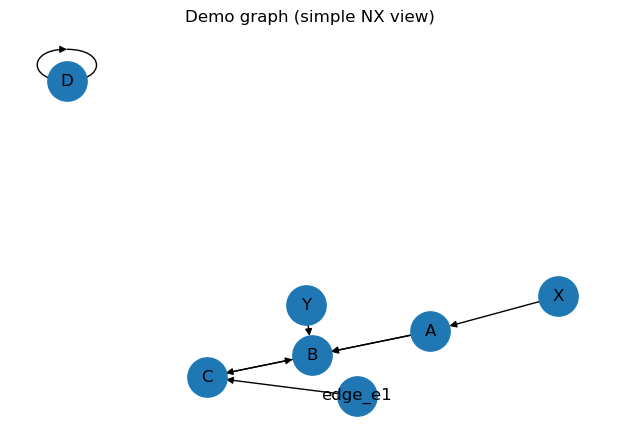

In [23]:
import matplotlib.pyplot as plt
import networkx as nx

# Obtain a simple NX view (collapse Multi* edges with sensible aggregations)
nxG, manifest = an.to_nx(G, directed=True, hyperedge_mode="skip") # skip, expand or reify
pos = nx.spring_layout(nxG, seed=42)
plt.figure(figsize=(6,4))
nx.draw(nxG, pos, with_labels=True, node_size=800)
nx.draw_networkx_edge_labels(nxG, pos, edge_labels=nx.get_edge_attributes(nxG, 'weight'))
plt.title('Demo graph (simple NX view)')
plt.show()

## 2) Run a few NX (NetworkX) algorithms via the proxy

In [26]:
# Shortest path over weights (collapse parallel edges first)
sp_len = G.nx.shortest_path_length(G, source='A', target='D', weight='weight', _nx_simple=True)
sp = G.nx.shortest_path(G, source='A', target='D', weight='weight', _nx_simple=True)
print('Shortest path length A→D:', sp_len)
print('Shortest path A→D:', sp)

# Betweenness centrality (weighted)
bc = G.nx.betweenness_centrality(G, weight='weight', _nx_simple=True)
bc

Shortest path length A→D: 1.0
Shortest path A→D: ['A', 'D']


C:\Users\pc\anaconda3\Lib\site-packages\annnet\core\graph.py:6857: RuntimeWarning: AnnNet→NX conversion is lossy: multiple layers flattened into single NX graph.
  nxG = self._convert_to_nx(


{'A': 0.1,
 'B': 0.1,
 'C': 0.2,
 'D': 0.03333333333333333,
 'X': 0.0,
 'Y': 0.0,
 'edge_e1': 0.0}

In [28]:
# Community detection using Label Propagation (works on undirected views)
comms = list(G.nx.asyn_lpa_communities(G, weight='weight', _nx_directed=False, _nx_simple=True))
comms

[{'A', 'B', 'C', 'D', 'X', 'Y', 'edge_e1'}]

## 3) Interoperability (adapters)

In [33]:
# Top-level adapter function (returns NX graph; may also return a manifest)
from pathlib import Path

nx_out = an.to_nx(G, directed=True, hyperedge_mode='expand')
nxG2 = nx_out[0] if isinstance(nx_out, tuple) else nx_out
assert isinstance(nxG2, (nx.AnnNet, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph))

# Optional: export to GraphML and SIF for demonstration
assets = Path('showcase'); assets.mkdir(exist_ok=True, parents=True)
an.to_graphml(G, assets/'demo.graphml')
an.to_sif(G, assets/'demo.sif')
str(assets.resolve())

'C:\\Users\\pc\\_VIXYN\\TST\\showcase'

## 4) Import repressilator (Elowitz) from SBML

In [36]:
# Path relative to this notebook (the repo includes docs/Elowitz.sbml.xml)
sbml_path = 'Elowitz.sbml.xml'
print('SBML file:', sbml_path)
R = an.from_sbml(str(sbml_path)) if sbml_path else None
R

SBML file: Elowitz.sbml.xml


Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction1 "degradation of LacI transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction1 "degradation of LacI transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction2 "degradation of TetR transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction2 "degradation of TetR transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction3 "degradation of CI transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction3 "degradation of CI transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction4 "translation of LacI">'
Missing upper flux bound se

In [38]:
if R is not None:
    print('Repressilator — vertices:', R.num_vertices, 'edges:', R.num_edges)
    R.edges_view().head(10)

Repressilator — vertices: 8 edges: 12


## 5) Save & load the lossless `.annnet` format

In [41]:
out_dir = Path('showcase'); out_dir.mkdir(exist_ok=True, parents=True)
demo_path = out_dir/'demo.annnet'
sbml_path_out = out_dir/'repressilator.annnet'

G.write(demo_path, overwrite=True)  # lossless save
print('Wrote:', demo_path)

# Round-trip check
G2 = an.AnnNet.read(demo_path)
print('Round-trip OK?', (G2.num_vertices, G2.num_edges) == (G.num_vertices, G.num_edges))

if R is not None:
    R.write(sbml_path_out, overwrite=True)
    print('Saved repressilator to:', sbml_path_out)

Wrote: showcase\demo.annnet
Round-trip OK? True
Saved repressilator to: showcase\repressilator.annnet
